# Hands-on session: Machine Learning & Data Visualization
---
## 4 - Best practices in ML pipelines
---


How do I use this?

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sina-mansour/OHBM-Brainhack-2021/blob/main/notebooks/04_best_practices.ipynb) | [![View the notebook](https://img.shields.io/badge/render-nbviewer-orange.svg)](https://nbviewer.jupyter.org/github/sina-mansour/OHBM-Brainhack-2021/blob/main/notebooks/04_best_practices.ipynb?flush_cache=true)

---

package installation for google colab:

In [ ]:
# install required packages for colab
!wget "https://raw.githubusercontent.com/sina-mansour/OHBM-Brainhack-2021/main/colab/requirements.txt" && pip install -r requirements.txt


---

Loading packages

In [1]:
# pandas for data handling
import pandas as pd

# matplotlib and seaborn for data visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# setup inline plotting for jupyter
%matplotlib inline

# numpy for mathematical operations of data
import numpy as np

# nilearn and nibabel for handling neuroimaging data
import nilearn.datasets as nidata
import nilearn.plotting as niplot
import nibabel as nib

# sklearn is python's base of operations for everything ML
import sklearn

# statsmodels is more of an statistical inference toolbox for python
import statsmodels



---

We aim to explore some key best practices that one might commonly come across when doing machine learning in neuroimaging research.

We will focus on the regression example used in the previous sections to predict age from cortical information. So first, let's run the following cells to predict age from a few neuroimaging properties: 

In [19]:
# load the data from file
data = pd.read_csv('https://raw.githubusercontent.com/sina-mansour/OHBM-Brainhack-2021/main/data/abide2.tsv', sep='\t')

# The filter() method allows us to select variables by name--
# in this case, we put all features that match 'fs' in X_all.
X_all = data.filter(like='fs')

# for the sake of simplicity we'll only use a portion of the whole feature set
N_FEATURES = 5

# pandas DFs have a helpful sample() method for sampling rows/columns
X_sample = X_all.sample(N_FEATURES, axis=1, random_state=100)

# Split feature set with a fixed random seed for reproducibility
X_sample_train, X_sample_test = sklearn.model_selection.train_test_split(X_sample, test_size=200, random_state=123)
X_all_train, X_all_test = sklearn.model_selection.train_test_split(X_all, test_size=200, random_state=123)

# Split the demographic information
age = data['age']
sex = data['sex']
group = data['group']

age_train, age_test = sklearn.model_selection.train_test_split(age, test_size=200, random_state=123)
sex_train, sex_test = sklearn.model_selection.train_test_split(sex, test_size=200, random_state=123)
group_train, group_test = sklearn.model_selection.train_test_split(group, test_size=200, random_state=123)

# linear regression
linear = sklearn.linear_model.LinearRegression()
linear.fit(X_sample_train, age_train)
age_test_predicted_linear = linear.predict(X_sample_test)

# SVR with rbf kernel
svr = sklearn.svm.SVR()
svr.fit(X_sample_train, age_train)
age_test_predicted_svr = svr.predict(X_sample_test)

# report evaluation of RMSE
from sklearn.metrics import mean_squared_error, r2_score
print('RMSE of the linear model', mean_squared_error(age_test, age_test_predicted_linear, squared=False))
print('RMSE of the svr model', mean_squared_error(age_test, age_test_predicted_svr, squared=False))


RMSE of the linear model 7.501368370225271
RMSE of the svr model 8.121202595458605


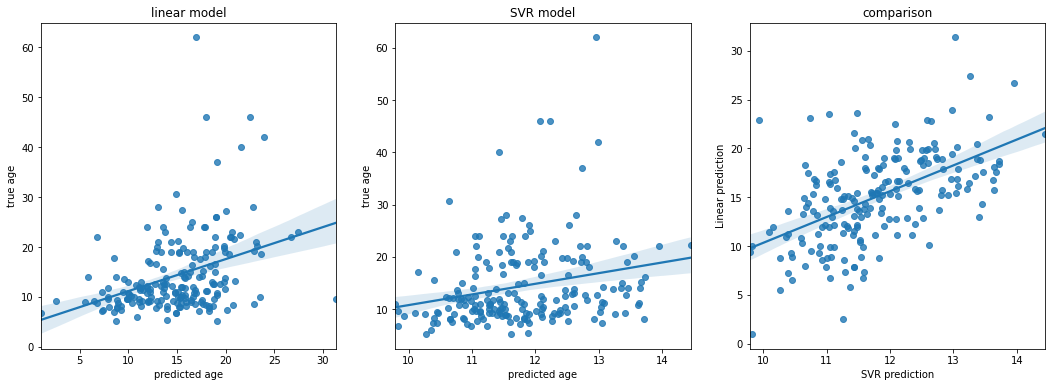

In [14]:
# create a figure
fig, axes = plt.subplots(ncols=3, figsize=(18, 6))

# scatter brain data vs. age
sns.regplot(x=age_test_predicted_linear, y=age_test, ax=axes[0])
axes[0].set_xlabel('predicted age')
axes[0].set_ylabel('true age')
axes[0].set_title('linear model')

sns.regplot(x=age_test_predicted_svr, y=age_test, ax=axes[1])
axes[1].set_xlabel('predicted age')
axes[1].set_ylabel('true age')
axes[1].set_title('SVR model')

sns.regplot(x=age_test_predicted_svr, y=age_test_predicted_linear, ax=axes[2])
axes[2].set_xlabel('SVR prediction')
axes[2].set_ylabel('Linear prediction')
axes[2].set_title('comparison');



---

## Standardization and Normalization

Standardization and normalizations are preprocessing steps that are commonly used in various machine learning pipelines. The main aim of these approaches is to remove the potential biases that the feature scales may create in fitting the prediction models. Both of the mentioned methods are means of scaling the feature space into a uniform scaling standard:

- Normalization is a scaling technique in which values are shifted and rescaled so that they end up ranging between 0 and 1. It is also known as Min-Max scaling.

- Standardization is another scaling technique where the values are centered around the mean with a unit standard deviation. This means that the mean of the attribute becomes zero and the resultant distribution has a unit standard deviation.

The first question we need to address – why do we need to scale the variables in our dataset? Some machine learning algorithms are sensitive to feature scaling while others are virtually invariant to it.

Machine learning algorithms like *linear regression*, *logistic regression*, *neural networks*, etc. that use **gradient descent** as an optimization technique require data to be scaled. To ensure that the gradient descent moves smoothly towards the minima and that the steps for gradient descent are updated at the same rate for all the features, we should scale the data before feeding it to the model. 

Distance algorithms like *KNN*, *K-means*, and *SVM* are most affected by the range of features. This is because behind the scenes they are using distances between data points to determine their similarity.

Question – Normalize or Standardize?

Normalization vs. standardization is a pivotal question:

- Normalization is good to use when you know that the distribution of your data does not follow a Gaussian distribution. This can be useful in algorithms that do not assume any distribution of the data like K-Nearest Neighbors and Neural Networks.

- Standardization, on the other hand, can be helpful in cases where the data follows a Gaussian distribution. However, this does not have to be necessarily true. Also, unlike normalization, standardization does not have a bounding range. So, even if you have outliers in your data, they will not be affected by standardization.


All that being said, as a **best practice recommendation**: You can always start by fitting your model to raw, normalized and standardized data and compare the performance for best results.

Here, as we're working with data that is expected to have a normal distribution, we'll implement a sample standardization. In the next cell we'll use the `StandardScaler` method from `sklearn.preprocessing` to standardize the models and see how it impacts the models performance:


In [6]:
# import the appropriate scaler function
from sklearn.preprocessing import StandardScaler

# Scalers are also implemented as estimators which transform input data
# make sure to only use the train data for scaling to avoid data leakage
standard_scaler = StandardScaler().fit(X_sample_train)

# Use the scaler to transform the training sample:
X_sample_train_scaled = standard_scaler.transform(X_sample_train)


In [12]:
X_sample_train.mean(axis=0)

fsCT_R_a24_ROI        3.102525
fsArea_R_d32_ROI    441.583333
fsCT_L_PBelt_ROI      2.646780
fsLGI_L_POS2_ROI    745.168595
fsVol_L_FOP1_ROI    588.421642
dtype: float64

In [11]:
X_sample_train_scaled.mean(axis=0)

array([-5.91014247e-16,  2.48557394e-16, -1.05167395e-15, -2.16521107e-16,
        1.94427117e-16])

In [25]:
# linear regression
linear_scaled = sklearn.linear_model.LinearRegression()
linear_scaled.fit(X_sample_train_scaled, age_train)
age_test_predicted_linear_scaled = linear_scaled.predict(standard_scaler.transform(X_sample_test))

# SVR with rbf kernel
svr_scaled = sklearn.svm.SVR()
svr_scaled.fit(X_sample_train_scaled, age_train)
age_test_predicted_svr_scaled = svr_scaled.predict(standard_scaler.transform(X_sample_test))

# report evaluation of RMSE
from sklearn.metrics import mean_squared_error
print('RMSE of the standardized linear model', mean_squared_error(age_test, age_test_predicted_linear_scaled, squared=False))
print('RMSE of the standardized svr model', mean_squared_error(age_test, age_test_predicted_svr_scaled, squared=False))

RMSE of the standardized linear model 7.5013683702249825
RMSE of the standardized svr model 7.186874470699966


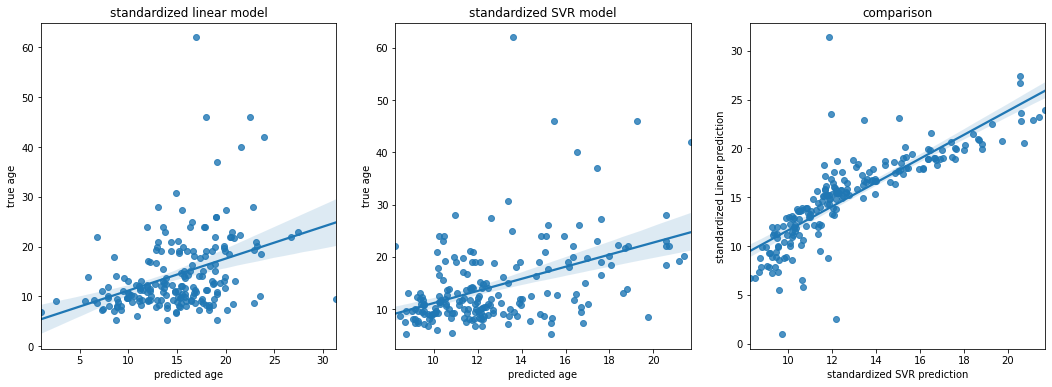

In [26]:
# create a figure
fig, axes = plt.subplots(ncols=3, figsize=(18, 6))

# scatter brain data vs. age
sns.regplot(x=age_test_predicted_linear_scaled, y=age_test, ax=axes[0])
axes[0].set_xlabel('predicted age')
axes[0].set_ylabel('true age')
axes[0].set_title('standardized linear model')

sns.regplot(x=age_test_predicted_svr_scaled, y=age_test, ax=axes[1])
axes[1].set_xlabel('predicted age')
axes[1].set_ylabel('true age')
axes[1].set_title('standardized SVR model')

sns.regplot(x=age_test_predicted_svr_scaled, y=age_test_predicted_linear_scaled, ax=axes[2])
axes[2].set_xlabel('standardized SVR prediction')
axes[2].set_ylabel('standardized Linear prediction')
axes[2].set_title('comparison');



Now that we have standardized the data, let's fit another regression model:

---
## Cross-validation

It's important to note that an estimator will almost always perform better when evaluated on the same data it was trained on than when evaluated on an entirely new dataset. Since our estimators are of little use to us unless they can generalize to new data, we should probably care much more about how an estimator performs on new data than on data it's already seen. That is, we want what's known as an **out-of-sample** estimate of performance.

The most straightforward way to estimate out-of-sample performance is to ensure that we always train and evaluate our estimator on independent datasets. The performance estimate obtained from the training dataset will typically suffer from overfitting to some degree; the test dataset estimate will not, so long as its error is independent of the training dataset.

In practice, an easy way to construct training and test datasets with independent errors is to randomly split a dataset in two. We can make use of scikit-learn's `train_test_split` utility, found in the [model selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection) module, to do the work for us.

This concept was used all along in the previous sections. Let's see this in action:

In [29]:
# linear regression
linear_scaled = sklearn.linear_model.LinearRegression()
linear_scaled.fit(X_sample_train_scaled, age_train)
age_test_predicted_linear_scaled = linear_scaled.predict(standard_scaler.transform(X_sample_test))

# report evaluation of RMSE
print('RMSE of the standardized linear model (train)', mean_squared_error(age_train, linear_scaled.predict(X_sample_train_scaled), squared=False))
print('RMSE of the standardized linear model (test)', mean_squared_error(age_test, age_test_predicted_linear_scaled, squared=False))


RMSE of the standardized linear model (train) 8.665966285119048
RMSE of the standardized linear model (test) 7.5013683702249825


This was unexpected!

But is mainly due to the lack of enough features in the model. Here's what would happen if all training samples were used:

In [31]:
# linear regression
linear_all = sklearn.linear_model.LinearRegression()
linear_all.fit(X_all_train, age_train)
age_test_predicted_linear_all = linear_all.predict(X_all_test)

# report evaluation of RMSE
print('RMSE of the linear model (train)', mean_squared_error(age_train, linear_all.predict(X_all_train), squared=False))
print('RMSE of the linear model (test)', mean_squared_error(age_test, age_test_predicted_linear_all, squared=False))


RMSE of the linear model (train) 3.954905986700405e-12
RMSE of the linear model (test) 17.39314462342137


The difference here is remarkable. In the training sample, the fitted model explains all of the variance. In the test sample, it explains... well, none. Actually, the value is negative! (If you're used to computing $R^2$ by taking the square of a correlation coefficient, you might think this is an error, but it isn't. The [standard definition of $R^2$](https://en.wikipedia.org/wiki/Coefficient_of_determination) allows arbitrarily large negative values, because the residual sum-of-squares (RSS) can be larger than the total sum-of-squares (TSS). Intuitively, we can have an estimator that's so bad, we would have been better off just using the mean of the new data as our prediction.)

#### When less is more
The reason our linear regression model overfits our data in this case is that, just as we saw in the simulated examples above, the model has too much flexibility relative to the data. You might intuitively think that 800 subjects would be enough to prevent overfitting, but sadly there's no such heuristic. What matters is the flexibility of the model *in relation to* the amount of available training data. In our case, even if we think 500 subject is a large number, we still have far more features than subjects:


In [32]:
X_all_train.shape

(804, 1440)

As observed earlier, A simple way to mitigate overfitting is to use fewer features. However, simply throwing away data is not the best way to control overfitting.


We'll need to further extend the idea of sample splitting to include a machine learning design that does not overfit and also allows for parameter tuning withing the model to increase the out of sample prediction accuracy.



---
## Hyperparemeter tuning


### Concept of K-fold cross-validation
We plan to a form of cross-validation known as <i>k</i>-fold cross-validation. The idea here is very similar to splitting our data into training and testing halves. In fact, if we set <i>k</i>—a parameter that represents the number of *folds*, or data subsets—to 2, we again end up with two discrete subsets of the data.

But now, there's an important twist: instead of using one half of the data for training and the other half for testing, we're going to use both halves for both training and testing. The key is that we'll take turns. First, we'll use Half 1 to train, and Half 2 to test; then, we'll reverse the process. Our final estimate of the model's out-of-sample performance is obtained by averaging the performance estimates we got from the two testing halves. In this way, we've managed to use every single one of our data points for both training and testing, but—critically—never for both at the same time.

Of course, we don't have to set <i>k</i> to 2; we can set it to any other value between 2 and the total sample size <i>n</i>. At the limit, if we set <i>k = n</i>, the approach is called  *leave-one-out cross-validation* (because in every fold, we leave out a single data point for testing, and use the rest of the dataset for training). In practice, <i>k</i> is most commonly set to a value in the range of 3 - 10 (there are principled reasons to want to avoid large values of <i>k</i> in many cases, but we won't get into the details here).

<img src="https://miro.medium.com/max/4698/1*GH7h526OcmtDy3Q1jeOjHw.png" width="900">
    
    
Image from <a href="https://medium.com/analytics-vidhya/training-validation-and-test-set-in-machine-learning-7fab555c1080">https://medium.com/analytics-vidhya/training-validation-and-test-set-in-machine-learning-7fab555c1080</a>


In [34]:
from sklearn.model_selection import GridSearchCV

# svr parameter space for tuning
parameters = {'kernel':('linear', 'rbf'), 'C':[0.1, 1, 10, 100],}

# SVR with gridsearch
svr_scaled = sklearn.svm.SVR()
gridsearch_svr = GridSearchCV(svr, parameters)
gridsearch_svr.fit(X_sample_train_scaled, age_train)
age_test_predicted_gridsearch_svr_scaled = gridsearch_svr.predict(standard_scaler.transform(X_sample_test))

print('RMSE of the standardized linear model (train)', mean_squared_error(age_train, gridsearch_svr.predict(X_sample_train_scaled), squared=False))
print('RMSE of the standardized linear model (test)', mean_squared_error(age_test, age_test_predicted_gridsearch_svr_scaled, squared=False))


RMSE of the standardized linear model (train) 8.1075351597889
RMSE of the standardized linear model (test) 7.188416693624316


---
## Evaluating overfitting vs. underfitting